# Finding Patterns in Data
## LSI and Scikit-Learn
    Jane Slagle
    Vol 3 Lab whoot whoot yeahhhh
    10/11/22

In [1]:
import os
import string
import numpy as np
from math import log
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Problem 1
- Perform PCA on the breast cancer dataset
- Graph the first two principal components
- Calculate the variance captured by the first two principal components

In [2]:
def prob1():
    """Recreate the plot in Figure 1 by performing PCA on the breast 
    cancer dataset. Translate the columns of X to have mean 0.
    Include the amount of variance captured by the first two principal 
    components in the graph title."""
    
    #load data:
    cancer = datasets.load_breast_cancer()
    X = cancer.data
    y = cancer.target  #class labels (0 or 1), will tell you if benign or malignant
    
    #PCA process: step 1 - need find Y matrix: Y is matrix w/ columns of X translated to have mean 0
    Y = X - np.mean(X, axis = 0) #want mean of each component of Y to be 0, axis=0 means take mean along each column
    
    #step 2 - find truncated SVD of our centered data (so of Y)
    U, Sig, VT = la.svd(Y)
    
    #step 3 - want to only keep the 1st 2 principal components: given formula for how do this in lab manual
    Y_hat = Y@VT.T[:, :2] #l = 2 in formula given
    
    #make mask to separate the data into the 2 types: bengin, malignant
    ben = Y_hat[y == 1]  #if the data is 1: its benign
    mal = Y_hat[y == 0]  #if the data is 0: its malignant
    
    #find variance w/ equation 1.1 in lab manual:
    variance = (Sig**2)/np.sum(Sig**2)  #need to square them bc not squared in the matrix
    
    #graph the 1st 2 principal components w/ 1st along x-axis
    plt.figure(figsize = (10, 7))
    plt.scatter(ben[:,0], ben[:, 1], marker = 'o', label = "benign", color = "mediumpurple") #need graph the x,y points
    plt.scatter(mal[:,0], mal[:,1], marker = 'o', label = "malignant", color = "tomato") 
    plt.legend(loc = "best")
    plt.xlabel("First Principle Component", color = "navy")
    plt.ylabel("Second Principle Component", color = "navy")
    plt.title("Breast Cancer PCA, variance = " + str(variance[0]+variance[1]), color = "navy") #want variance for 1st 2 principal components
    plt.show()   

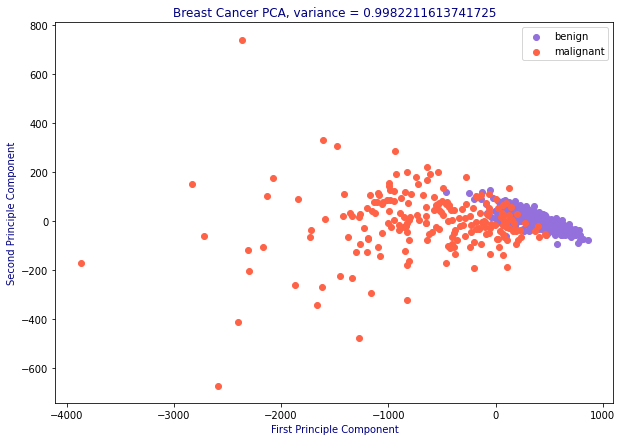

In [3]:
prob1()

## Problem 2
Implement the function similar()

In [4]:
def similar(i, Xhat):
    """
    Takes an index and matrix representing the principal components 
    of a document and returns two indices: the index of the document 
    that is least similar and the index of the document that is most 
    similar to i.
    
    Parameters:
        i: index of a document
        Xhat: decomposed data
    
    Returns:
        index_min: index of the document least similar to document i
        index_max: index of the document most similar to document i
    """
    vals = []  #list to store the similiarity values in
    
    #loop through every row of Xhat matrix: j represents a row, index i given is a row as well
    for j in range(Xhat.shape[0]):  #have to do .shape instead of length bc sparse and len wont work. [0] says loop through rows 
        vals.append(np.dot(Xhat[i], Xhat[j]) / (la.norm(Xhat[i])*la.norm(Xhat[j]))) #given in lab manual: this is similarity btw doc i, doc j
        
    #now need to get the least similar, most similar
    #argmax though will return itself (will return that a paper is most sim to itself) so use argsort instead
    #bc argsort goes from least to greatest so [-1] is one that is most similar w/ itself which is one want avoid
    #so get argsort at [-2] to get the actual one want
    most_sim = np.argsort(vals)[-2]
    least_sim = np.argmin(vals)      #know from lab manual that least sim is argmin of formula for vals
    
    return least_sim, most_sim

In [10]:
#test prob 2:

#generate random sparse matrix:
#Xhat = np.random.random((5,5))
#similar(4, Xhat)

### Function for Problem 3

In [6]:
def document_converter():
    """
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents.
    
    Returns:
        X ((n x m) sparse matrix): Each row represents a document
        paths (list): list where each element is a speech path 
            eg: path[0] is './Addresses/1990-Bush.txt'
    """
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = [folder+p for p in os.listdir(folder) if p.endswith(".txt")]

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) # Union sets together

    # Load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # Remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}


    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents.
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, storing counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_index.append(vocab[word])
                    counts.append(count)
                    doc_index.append(doc)

    # Create sparse matrix holding these word counts.
    X = sparse.csr_matrix((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=float)
    return X, paths

## Problem 3
Use the function above and PCA to find speeches most and least similar to a given speech.

In [7]:
def prob3(speech, l=7):
    """
    Uses LSI, applied to the word count matrix X, with the first 7 
    principal components to find the most similar and least similar 
    speeches.

    Parameters:
        speech (str): Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """    
    #apply LSI techniques to word count matrix X: the LSI techs here is the document converter function given
    #use document converter to get sparse matrix X of documents, list of paths called paths
    X, paths = document_converter()
    
    #need to get Xhat sparse matrix for when we use prob 2 function:
    U, Sigma, VT = sparse.linalg.svds(X, l) #in order to get Xhat, need to find svd
    Xhat = X@VT.T[:, :l] #only want 1st 7 principal components
    
    #need the index for when use prob 2 function:
    ind = paths.index(speech)  #want get the index of each speech
    
    #now use prob 2 func to find index of which documents are most, least similar
    minInd, maxInd = similar(ind, Xhat)
    
    return paths[maxInd][12:-4], paths[minInd][12:-4]  #do it at [12:-4] so that dont have address string in front of it

In [8]:
# Run this box once you have written prob3()
speech = './Addresses/1984-Reagan.txt'
print(prob3(speech))

speech = "./Addresses/1993-Clinton.txt"
print(prob3(speech))

('1988-Reagan', '1946-Truman')
('2010-Obama', '1951-Truman')


## Problem 4
Edit the end of the following function to return a weighted sparse matrix A.

In [9]:
def weighted_document_converter():
    """
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents. It gives weights
    to the most important words in the vocabulary.
    
    Returns:
        A ((n x m) sparse matrix): Each row represents a document
        paths (list): list where each element is a speech path 
            eg: path[0] is './Addresses/1990-Bush.txt'
    """
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = [folder+p for p in os.listdir(folder) if p.endswith(".txt")]

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) # Union sets together

    # Load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # Remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}

    t = np.zeros(len(vocab)) # holds global count for each word
    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Get doc-term counts and global term counts
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, storing counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_index.append(vocab[word])
                    counts.append(count)
                    doc_index.append(doc)

    # Create sparse matrix holding these word counts:
    X = sparse.csr_matrix((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=float)    
    
    # Define the variables:
    #do the p, g, A equations given in lab manual:
    p = X / np.sum(X, axis=1)  #p equation given in lab manual
    m, n = X.shape             #need m,n to get g, A         
    
    #get g:
    g = np.zeros(n)            
    for j in range(n):         #now loop through n and make g equation
        g[j] = 1 + sum([np.dot(p[i,j],np.log(p[i,j] + 1))/np.log(m) for i in range(1,m)])  #g equation
    
    #get A:
    A = np.zeros([m, n])
    for i in range(m):
        for j in range(n):
            A[i, j] = g[j] * np.log(X[i, j] + 1) #A equation

    return sparse.csr_matrix(A), paths  #want return sparse matrix A, list of file paths

## Problem 5
Use the weighted_document_converter() function above and scikit-learn's PCA to find speeches most and least similar to a given speech.

In [10]:
def prob5(speech, l=7):
    """
    Uses LSI, applied to the globally weighted word count matrix A, with 
    the first 7 principal components to find the most similar and least 
    similar speeches.

    Parameters:
        speech (str): Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """
    #repeat prob 3 using your weighted document converter function, sklearns built in PCA decomposition
    X, paths = weighted_document_converter() #use weighted_document_converter instead of document_converter here
    X = X.toarray() #PCA fit_transform func cant take in sparse matrices
    
    #use built in PCA to find the PCA instead of doing the svd stuff:
    pca = PCA(n_components=l, svd_solver = 'full')    #create the PCA transformer with hyperparameters
    Xhat = pca.fit_transform(X)  #fit the transformer and transform the data
    
    #need the index for when use prob 2 function:
    ind = paths.index(speech)    #want get the index of each speech
    
    #now use prob 2 func to find index of which documents are most, least similar
    minInd, maxInd = similar(ind, Xhat)
    
    return paths[maxInd][12:-4], paths[minInd][12:-4]  #do it at [12:-4] so that dont have address string in front of it

In [11]:
# Run this box after you have completed prob5()
speech = './Addresses/1984-Reagan.txt'
print(prob5(speech))

speech = "./Addresses/1993-Clinton.txt"
print(prob5(speech))

('1985-Reagan', '1961-Kennedy')
('1994-Clinton', '1951-Truman')


# This problem seems more reasonable than problem 3 because the least similar speeches are really old and the most similar speeches are the same presidents booYUH take THAT!

## Problem 6
- Split the breast cancer dataset into training and testing sets using random_state=2
- Fit KNeighborsClassifier and RandomForestClassifier to the training data
- Predict labels for the testing set
- Print a classification_report for each classifier
- Write a few sentences explaining which classifier would be better to use in this situation and why

In [2]:
#get cancer dataset again:
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

#split data into training, testing sets w/ random_state = 2:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2)

#do everything for KNeighborsClassifier:
#fit KNeighborsClassifier to the training data:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

#predict labels for the testing set:
knn_predicted = knn.predict(X_test)

#do everything for RandomForestClassifier:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)  #fit to the training data
forest_predicted = forest.predict(X_test)  #predict labels for the testing set

#print classification_report for each classifier:
print("KNeighorsClassifier:")
print(classification_report(y_test, knn_predicted))
print("")
print("RandomForestClassifier:")
print(classification_report(y_test, forest_predicted))

KNeighorsClassifier:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        56
           1       0.94      0.90      0.92        87

    accuracy                           0.90       143
   macro avg       0.89      0.90      0.90       143
weighted avg       0.90      0.90      0.90       143


RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        56
           1       0.96      0.94      0.95        87

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143



# A higher score means a better classifier so the RandomForestClassifier is better than the KNeighborsClassifier. The dataset here is for cancer, so it is not clustering so the random forest classifier will be better than the K neighbors one. The random forest would be better for data that is more clustered around a single point. HOWEVER, the k neighbors classifier would be better to use if the data is in different clusters

# booYUH again!

## Problem 7
- Use the breast cancer dataset split from Problem 6
- Run a GridSearch with a RandomForestClassifier, modifying at least three parameters.
- Use scoring="f1"
- Print out best_params_ and best_score_
- Print a confusion matrix for the test data

In [3]:
#want use breast cancer dataset split from prob 6:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2)

forest = RandomForestClassifier() #want run GridSearch w/ RandomForestClassifier

#to see what parameters have, use the code: RandomForestClassifier().get_params().keys()
#specify values for certain hyperparameters: want modify at least 3 parameters
param_grid = {"n_estimators": [3,4,5,6,7],   #just choose random values for each parameter
              "max_depth": [27,13,4,6,9],
              "min_samples_leaf": [1,2,56,8,7]}

forest_gs = GridSearchCV(forest, param_grid, scoring = "f1", n_jobs = -1) #told to use scoring=f1

#run the actual search now:
forest_gs.fit(X_train, y_train)

#after fitting: you can access the data about the results: want print best_params_, best_score_
print(forest_gs.best_params_, forest_gs.best_score_, sep = '\n')

#print confusion matrix for the test data:
forest_predicted = forest_gs.predict(X_test) #need this for when make the confusion matrix
CM = confusion_matrix(y_test, forest_predicted)
print(CM)

{'max_depth': 4, 'min_samples_leaf': 2, 'n_estimators': 6}
0.970601391535971
[[51  5]
 [ 5 82]]


## Problem 8
- Create a pipeline with a StandardScaler, PCA, and a KNeighborsClassifier
- Do a grid search, modifying at least 6 parameters
- Print your best parameters and best score (f1)
- Get a score of at least .96

In [3]:
#want use same train-test split as before:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2)

#create pipeline w/ StandardScaler, PCA, KNeighborsClassifier:
pipe = Pipeline([("scaler", StandardScaler()),
                 ("pca", PCA()),
                 ("knn", KNeighborsClassifier())])

#want modify at least 6 parameters so specify values for the hyperparameters choose:
pipe_param_grid = [{"knn__n_neighbors": [3,4,5,6,7],   #just choose random values for each parameter
              "knn__weights": ["uniform", "distance"],
              "pca__random_state": [1,2,56,8,7],
              "pca__tol": [3,4,5,6,7],
              "scaler__with_mean": [6,7,8,9,10],
              "scaler__with_std": [6, 7, 8, 9, 10]}]

#now do the gridsearch:
pipe_gs = GridSearchCV(pipe, pipe_param_grid, scoring = "f1", n_jobs = -1)
pipe_gs.fit(X_train, y_train)

#print best parameters and best score:
print(pipe_gs.best_params_, pipe_gs.best_score_, sep = '\n')

{'knn__n_neighbors': 4, 'knn__weights': 'distance', 'pca__random_state': 1, 'pca__tol': 3, 'scaler__with_mean': 6, 'scaler__with_std': 6}
0.9782136765623004
